<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/gan/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will build a generative adversarial network (GAN) trained on the MNIST dataset. From this we will be able to generate new handwritten digits. 

The process will be broken down into the following steps:

  1. Load and visualize the dataset
  2. Define a model
      - Define a discriminator network
      - Define a generator network
      - Build complete network
  3. Specify loss functions and optimizers
  4. Train the model
      - Discriminator training
          * Compute the discriminator loss on real images
          * Generate fake images
          * Compute the discriminator loss on fake, generated images
          * Add up real and fale losses
          * Update discriminator's weights (backprop + optimization)
      - Generator training
          * Generate fake images
          * Compute the discriminator loss on fake images using flipped labels
          * Update generator's weights (backprop + optimization)
  5. Generate new images


In [1]:
# import required libraries
import torch
import torchvision

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available!


### Load and visualiza dataset

In [17]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load dataset from torchvision.datasets 
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

# image classes in the dataset
classes = ['0','1','2','3','4','5', '6','7','8','9']
num_classes = len(classes)

In [18]:
# print out some data stats

print('Number of training images:', len(train_data))

for inputs, targets in train_loader:
  print("Image batch dimensions:", inputs.shape)
  print("Image label dimensions:", targets.shape)
  print("Class labels of 10 examples:", targets[:10])
  break

Number of training images: 60000
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


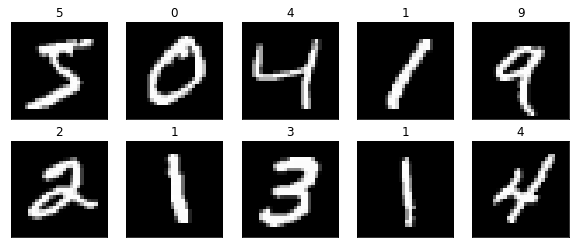

In [19]:
# visualize a batch of training data

def imshow(img):
  plt.imshow(np.squeeze(img), cmap="gray")

# obtain one batch on training images
dataiter = iter(train_loader)
inputs, targets = dataiter.next()
inputs = inputs.numpy()

# plot some images in the batch along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(inputs[idx])
  ax.set_title(str(targets[idx].item()))

### Define the model

In [22]:
# Discriminator network

import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim * 4)
    self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    out = self.fc4(x)
    return out

In [23]:
# Generator network

class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
    self.fc4 = nn.Linear(hidden_dim * 4, output_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    out = F.tanh(self.fc4(x))
    return out

In [25]:
# Discriminator hyparameters

# size of the input image to discriminator 
input_size = 28*28
# size of the discriminator output
d_output_size = 1
# size of the last hidden layer
d_hidden_size = 32

# Generator hyperparameters

# size of the latent vector
z_size = 100
# size of the generator output
g_output_size = 28*28
# size of the first hidden layer
g_hidden_size = 32

# Build complete network
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify loss functions and optimizers

In [26]:
# real image loss
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  # label smoothing
  labels = torch.ones(batch_size) * 0.9 if smooth else torch.ones(batch_size) 
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss

# fake image loss
def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss 

In [27]:
import torch.optim as optim

# specify optimizer
lr = 0.0001

# optimizer for discriminator
d_optimizer = optim.Adam(D.parameters(), lr)
# optimizer for generator
g_optimizer = optim.Adam(G.parameters(), lr)

### Train the model

### Generate new images